In [1]:
import os
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader


In [2]:
# -------------------------------------
# Dataset with noise injection (denoising)
# -------------------------------------
class CoinDataset(Dataset):
    def __init__(self, image_paths, transform=None, noise_level=0.1):
        self.image_paths = image_paths
        self.transform = transform
        self.noise_level = noise_level

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("L")  # Grayscale
        if self.transform:
            img = self.transform(img)

        noisy_img = img + self.noise_level * torch.randn_like(img)
        noisy_img = torch.clamp(noisy_img, 0., 1.)

        return noisy_img, img  # (input, target)


# -------------------------------------
# Deep Denoising Autoencoder
# -------------------------------------
class CoinAutoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(CoinAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=2, padding=1),     # -> [64, 112, 112]
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),   # -> [128, 56, 56]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),  # -> [256, 28, 28]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256 * 28 * 28, latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256 * 28 * 28),
            nn.ReLU(),
            nn.Unflatten(1, (256, 28, 28)),
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),  # -> [128, 56, 56]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),   # -> [64, 112, 112]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 3, stride=2, padding=1, output_padding=1),     # -> [1, 224, 224]
            nn.Sigmoid()
        )

    def forward(self, x):
        latent = self.encoder(x)
        recon = self.decoder(latent)
        return recon, latent




In [3]:
# -------------------------------------
# Load Data
# -------------------------------------
base_dir = "/home/alexander/bueschelquinare_preprocessed/obverse"
image_paths = glob.glob(f"{base_dir}/*/*.png")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = CoinDataset(image_paths, transform=transform, noise_level=0.1)
loader = DataLoader(dataset, batch_size=16, shuffle=True)


In [4]:
# -------------------------------------
# Train Autoencoder
# -------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CoinAutoencoder(latent_dim=128).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

num_epochs = 50
print("Training...")

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for noisy_imgs, clean_imgs in loader:
        noisy_imgs = noisy_imgs.to(device)
        clean_imgs = clean_imgs.to(device)

        recon, _ = model(noisy_imgs)
        loss = criterion(recon, clean_imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {epoch_loss / len(loader):.6f}")

print("Training complete.")


Training...
Epoch 1/50 - Loss: 0.042888
Epoch 2/50 - Loss: 0.029728
Epoch 3/50 - Loss: 0.026122
Epoch 4/50 - Loss: 0.022718
Epoch 5/50 - Loss: 0.020521
Epoch 6/50 - Loss: 0.018339
Epoch 7/50 - Loss: 0.016662
Epoch 8/50 - Loss: 0.014898
Epoch 9/50 - Loss: 0.013796
Epoch 10/50 - Loss: 0.012716
Epoch 11/50 - Loss: 0.011901
Epoch 12/50 - Loss: 0.011112
Epoch 13/50 - Loss: 0.010520
Epoch 14/50 - Loss: 0.009876
Epoch 15/50 - Loss: 0.009352
Epoch 16/50 - Loss: 0.008530
Epoch 17/50 - Loss: 0.008269
Epoch 18/50 - Loss: 0.007678
Epoch 19/50 - Loss: 0.007596
Epoch 20/50 - Loss: 0.007164
Epoch 21/50 - Loss: 0.006905
Epoch 22/50 - Loss: 0.006531
Epoch 23/50 - Loss: 0.006398
Epoch 24/50 - Loss: 0.006187
Epoch 25/50 - Loss: 0.005890
Epoch 26/50 - Loss: 0.005733
Epoch 27/50 - Loss: 0.005542
Epoch 28/50 - Loss: 0.005646
Epoch 29/50 - Loss: 0.005413
Epoch 30/50 - Loss: 0.005545
Epoch 31/50 - Loss: 0.005250
Epoch 32/50 - Loss: 0.005186
Epoch 33/50 - Loss: 0.004980
Epoch 34/50 - Loss: 0.004868
Epoch 35/50

In [5]:
# -------------------------------------
# Extract Latent Features & Save
# -------------------------------------
model.eval()
features = []
labels = []

with torch.no_grad():
    for path in image_paths:
        try:
            img = Image.open(path).convert("L")
            x = transform(img).unsqueeze(0).to(device)
            _, latent = model(x)
            features.append(latent.squeeze().cpu().numpy())
            labels.append(os.path.basename(os.path.dirname(path)))
        except Exception as e:
            print(f"Skipping {path}: {e}")

features = np.array(features)
labels = np.array(labels)

np.save("coin_latents.npy", features)
np.save("coin_labels.npy", labels)
print("Saved latent features and labels.")

# -------------------------------------
# Optional: Visualize reconstructions
# -------------------------------------
def visualize_reconstructions(model, dataset, num_images=5):
    model.eval()
    fig, axs = plt.subplots(num_images, 2, figsize=(6, num_images * 2))
    for i in range(num_images):
        noisy, clean = dataset[i]
        noisy_input = noisy.unsqueeze(0).to(device)
        with torch.no_grad():
            recon, _ = model(noisy_input)
        axs[i, 0].imshow(clean.squeeze().numpy(), cmap="gray")
        axs[i, 0].set_title("Original")
        axs[i, 1].imshow(recon.squeeze().cpu().numpy(), cmap="gray")
        axs[i, 1].set_title("Reconstructed")
    plt.tight_layout()
    plt.show()




Saved latent features and labels.


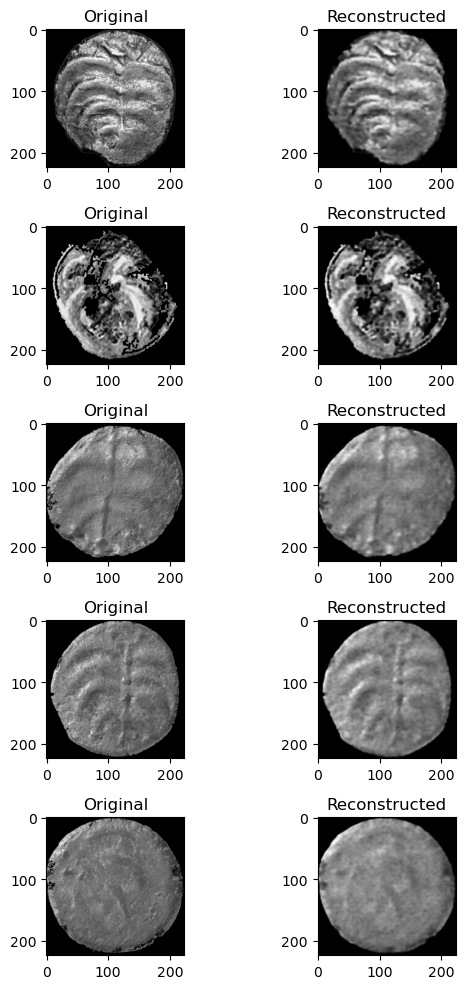

In [6]:
# Uncomment to see
visualize_reconstructions(model, dataset)

/home/alexander/miniforge3/envs/dc/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/alexander/miniforge3/envs/dc/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


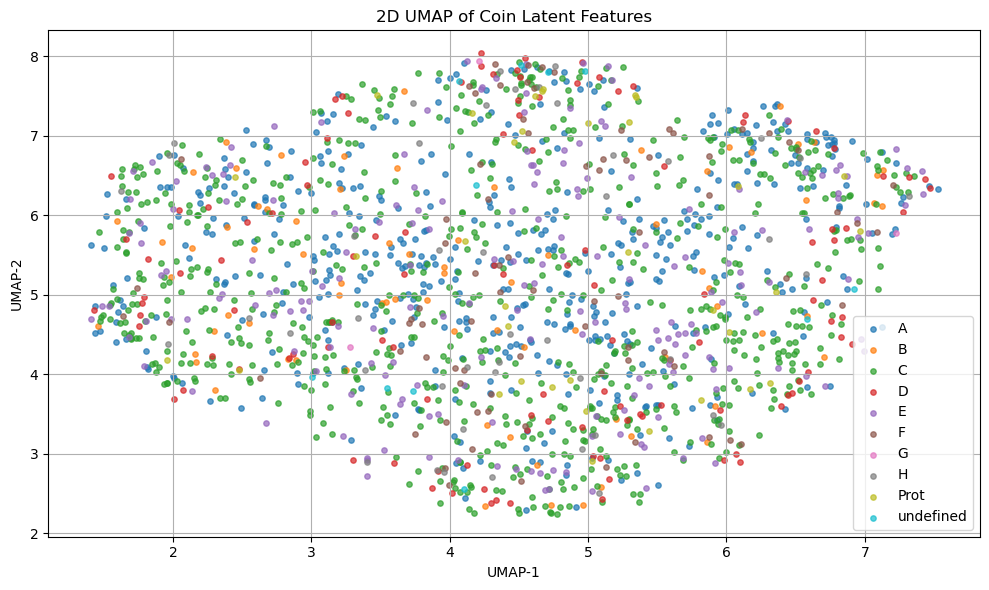

In [1]:
import numpy as np
import umap
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import LabelEncoder

# Load latent features and labels
features = np.load("coin_latents.npy")
labels = np.load("coin_labels.npy")

# Encode labels (e.g., A, B, C → 0, 1, 2)
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
label_names = label_encoder.classes_

# -------- 2D UMAP --------
umap_2d = umap.UMAP(n_components=2, random_state=42)
embeddings_2d = umap_2d.fit_transform(features)

plt.figure(figsize=(10, 6))
for label in np.unique(encoded_labels):
    idx = encoded_labels == label
    plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], label=label_names[label], s=15, alpha=0.7)
plt.legend()
plt.title("2D UMAP of Coin Latent Features")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
# -------- 3D UMAP with Plotly --------
umap_3d = umap.UMAP(n_components=3, random_state=42)
embeddings_3d = umap_3d.fit_transform(features)

fig = px.scatter_3d(
    x=embeddings_3d[:, 0],
    y=embeddings_3d[:, 1],
    z=embeddings_3d[:, 2],
    color=labels,
    title="3D UMAP of Coin Latent Features",
    labels={"color": "Folder"},
    opacity=0.7
)
fig.update_traces(marker=dict(size=3))
fig.show()
